Let's build a boundary integral solver!

# Part 1: Near-field evaluation via quadrature by expansion (QBX). 

TODO:

* check if there are better versions of QBX to use here. see the recent "robust" QBX papers from Klockner et al.

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# the n-point gauss quadrature rule on [-1, 1], returns tuple of (points, weights)
def gauss_rule(n):
    k = np.arange(1.0, n)
    a_band = np.zeros((2, n))
    a_band[1, 0:(n - 1)] = k / np.sqrt(4 * k * k - 1)
    x, V = scipy.linalg.eig_banded(a_band, lower=True)
    w = 2 * np.real(np.power(V[0, :], 2))
    return x, w

# the n-point trapezoidal rule on [-1, 1], returns tuple of (points, weights)
def trapezoidal_rule(n):
    return np.linspace(-1.0, 1.0, n + 1)[:-1], np.full(n, 2.0 / n)

# archetype of a simple curve function, returns  (x, y, nx, ny, jacobian)
# here the jacobian of the transformation is constant and equal to pi.
def circle(quad_pts):
    theta = np.pi * (quad_pts + 1)
    x = np.cos(theta)
    y = np.sin(theta)
    return x, y, x, y, np.pi

In [7]:
def double_layer_matrix(surface, quad_rule, obsx, obsy):
    srcx, srcy, srcnx, srcny, curve_jacobian = surface
    
    dx = obsx[:, None] - srcx[None, :]
    dy = obsy[:, None] - srcy[None, :]
    r2 = dx ** 2 + dy ** 2

    # double layer potential
    integrand = -1.0 / (2 * np.pi) * (dx * srcnx[None, :] + dy * srcny[None, :]) / r2
    
    return integrand * curve_jacobian * quad_rule[1][None, :]

In [8]:
nobs = 100
xs = np.linspace(-2, 2, nobs)
ys = np.linspace(-2, 2, nobs)
obsx, obsy = np.meshgrid(xs, ys)

quad_rule_low = trapezoidal_rule(50)
surface_low = circle(quad_rule_low[0])

BIE_matrix = double_layer_matrix(
    surface   = surface_low,
    quad_rule = quad_rule_low,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten()
)
u = BIE_matrix.dot(surface_low[1]).reshape(obsx.shape)

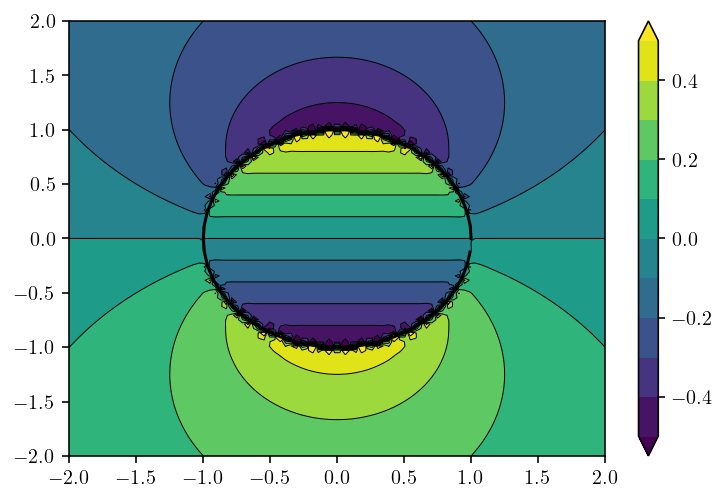

In [9]:
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
cntf = plt.contourf(xs, ys, u, levels = np.linspace(-0.5,0.5,11), extend="both")
plt.contour(xs, ys, u, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.5,0.5,11), extend="both")
plt.colorbar(cntf)
plt.show()

In [10]:
zoomnobs = 200
zoomx = [-1.4, -0.6]
zoomy = [-0.4, 0.4]
zoomxs = np.linspace(*zoomx, zoomnobs)
zoomys = np.linspace(*zoomy, zoomnobs)
zoomobsx, zoomobsy = np.meshgrid(zoomxs, zoomys)
zoomu_low = double_layer_matrix(surface_low, quad_rule_low, zoomobsx.flatten(), zoomobsy.flatten())\
    .dot(surface_low[1]).reshape(zoomobsx.shape)

quad_rule_high = trapezoidal_rule(2000)
surface_high = circle(quad_rule_high[0])
zoomu_high = double_layer_matrix(surface_high, quad_rule_high, zoomobsx.flatten(), zoomobsy.flatten())\
    .dot(surface_high[1]).reshape(zoomobsx.shape)

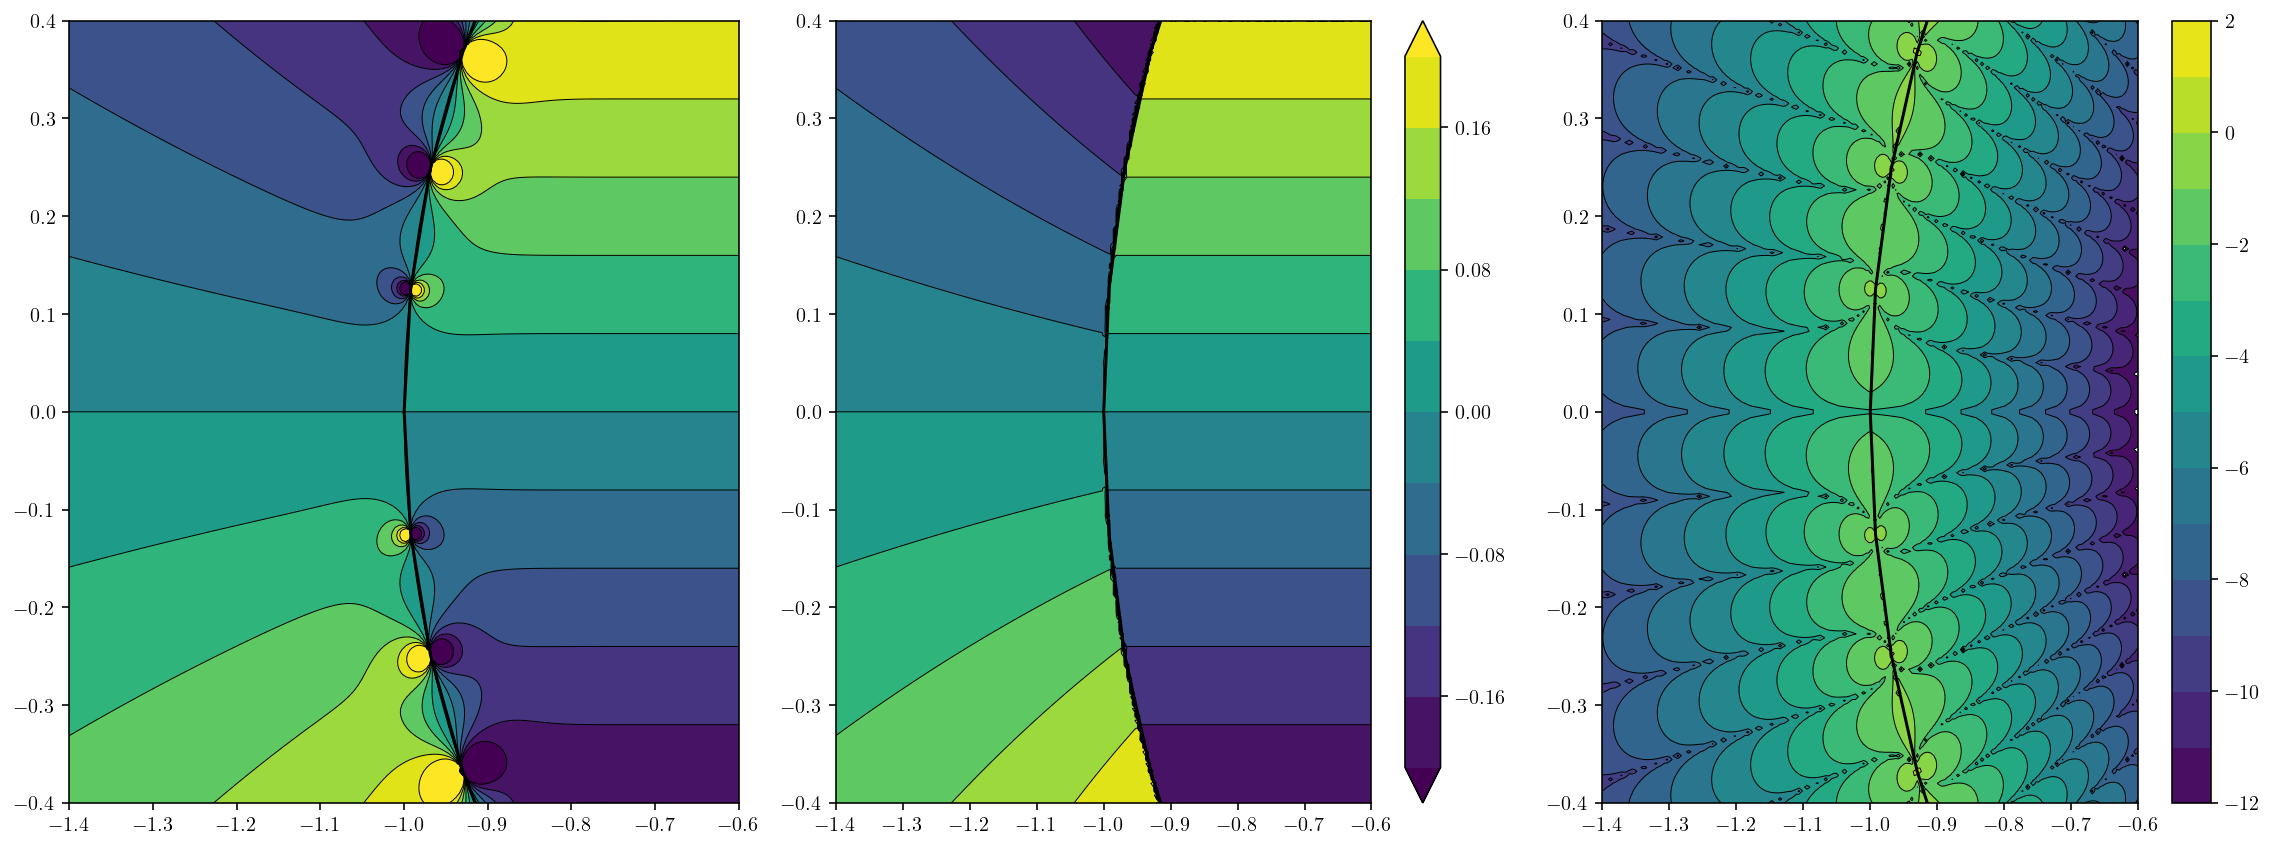

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
cntf = plt.contourf(zoomxs, zoomys, zoomu_low, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.contour(zoomxs, zoomys, zoomu_low, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 2)
cntf = plt.contourf(zoomxs, zoomys, zoomu_high, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.contour(zoomxs, zoomys, zoomu_high, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.colorbar(cntf)
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 3)
logerror = np.log10(np.abs(zoomu_low - zoomu_high))
cntf = plt.contourf(zoomxs, zoomys, logerror, levels = np.linspace(-12, 2, 15))
plt.contour(zoomxs, zoomys, logerror, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-12, 2, 15))
plt.colorbar(cntf)
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.tight_layout()
plt.show()

Many QBX methods. Here we'll use a version based on a complex power series. 

There are a few alternative forms of expansion:
* PDE-specific analytic expansions like that used in the original QBX paper 
* A kernel independent method called QBKIX that

In [12]:
qbx_p = 10
qbx_center_x = -1.5
qbx_center_y = 0.0
qbx_r = 0.25

trap_x, trap_ws = trapezoidal_rule(2 * qbx_p + 1)
trap_ws *= np.pi
trap_theta = np.pi * (trap_x + 1)

qbx_x = (qbx_r * np.cos(trap_theta) + qbx_center_x)
qbx_y = (qbx_r * np.sin(trap_theta) + qbx_center_y)
qbx_u = double_layer_matrix(surface_low, quad_rule_low, qbx_x, qbx_y).dot(surface_low[1])

alpha = []
for L in range(qbx_p):
    C = 1.0 / (np.pi * (qbx_r ** L))
    if L == 0:
        C /= 2.0
    alpha.append(C * np.sum(trap_ws * qbx_u * np.exp(-1j * L * trap_theta)))

zoom_complex = zoomobsx + zoomobsy * 1j
qbx_center = qbx_center_x + qbx_center_y * 1j
zoomu_qbx = np.zeros_like(zoomobsx)
for L in range(qbx_p):
    zoomu_qbx += np.real(alpha[L] * ((zoom_complex - qbx_center) ** L))

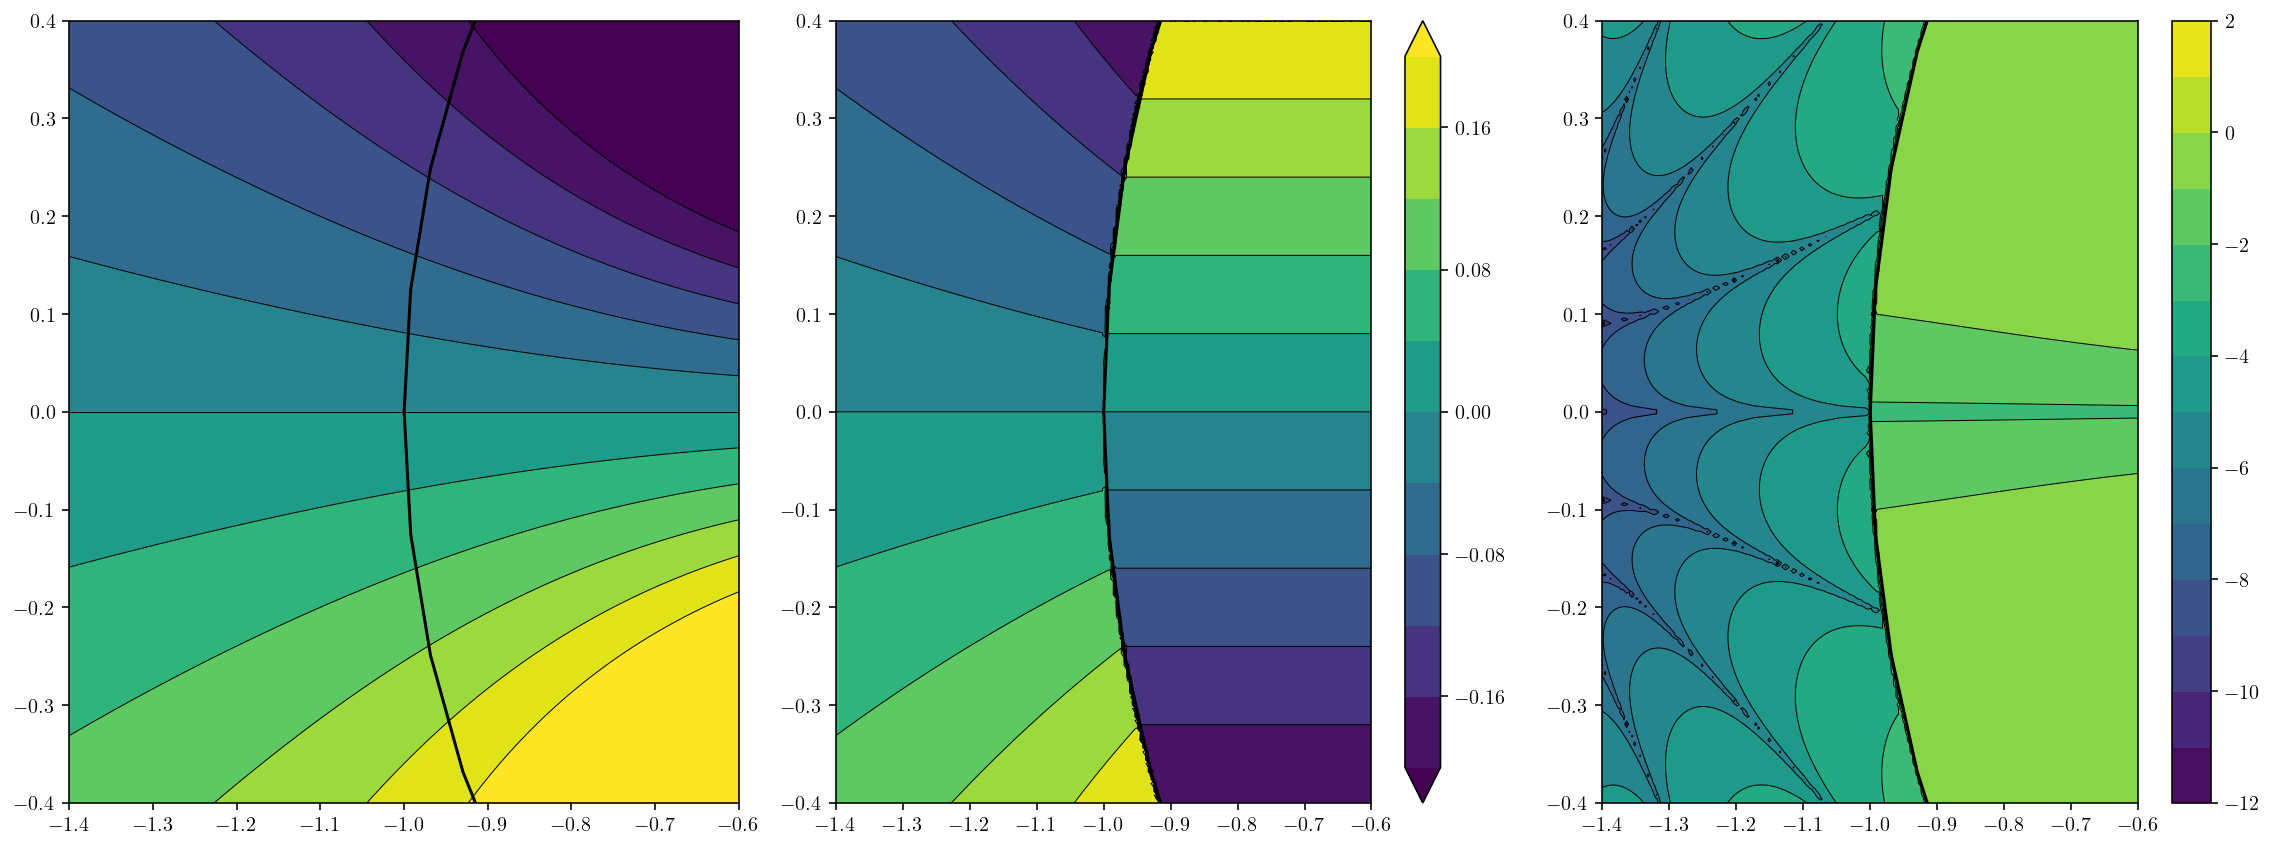

In [13]:
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
cntf = plt.contourf(zoomxs, zoomys, zoomu_qbx, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.contour(zoomxs, zoomys, zoomu_qbx, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 2)
cntf = plt.contourf(zoomxs, zoomys, zoomu_high, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.contour(zoomxs, zoomys, zoomu_high, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.colorbar(cntf)
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 3)
logerror = np.log10(np.abs(zoomu_qbx - zoomu_high))
cntf = plt.contourf(zoomxs, zoomys, logerror, levels = np.linspace(-12, 2, 15))
plt.contour(zoomxs, zoomys, logerror, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-12, 2, 15))
plt.colorbar(cntf)
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.tight_layout()
plt.show()